In [1]:
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import save_image
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
import logging

TRAIN_LOSSES_LOGFILE = "train_losses.log"

class LossesLogger(object):
    def __init__(self, file_path_name):
        if os.path.isfile(file_path_name):
            os.remove(file_path_name)
        
        self.logger = logging.getLogger("losses_logger")
        self.logger.setLevel(1)
        file_handler = logging.FileHandler(file_path_name)
        file_handler.setLevel(1)
        self.logger.addHandler(file_handler)
        
        header = ",".join(["Epoch", "Loss", "Value"])
        self.logger.debug(header)
    
    def log(self, epoch, losses_storer):
        for k, v in losses_storer.item():
            log_string = ",".join(str(item) for item in [epoch, k, sum(v)/len(l)])
            self.logger.debug(log_string)

In [3]:
from timeit import default_timer
from collections import defaultdict
from tqdm import trange

class Trainer():
    def __init__(self, model, optimizer, loss_f, device, logger=logging.getLogger(__name__),
                 save_dir="results", is_progress_bar=True):
            self.device = device
            self.model = model.to(device)
            self.loss_f = loss_f
            self.optimizer = optimizer
            self.save_dir = save_dir
            self.is_progress_bar = is_progress_bar
            self.logger = logger
            self.losses_logger = LossesLogger(os.path.join(self.save_dir, TRAIN_LOSSES_LOGFILE))
            self.logger.info("Training Device: {}".format(self.device))
            
    def __call__(self, data_loader, epochs=10, checkpoint_every=10):
        start = default_timer()
        self.model.train()
        for epoch in range(epochs):
            storer = defaultdict(list)
            mean_epoch_loss = self._train_epoch(data_loader, storer, epoch)
            mean_epoch_loss = self._test_epoch(data_loader, storer, epoch)
            with torch.no_grad():
                sample = torch.randn(64, self.model.latent_dim).to(device)
                sample = self.model.decoder(sample).cpu()  # make sure on cpu
                save_image(sample.view(64, 1, 32, 32),
                           './results/samples/' + str(epoch) + '.png')
            
    def _train_epoch(self, data_loader, storer, epoch):
        epoch_loss = 0.
        kwargs = dict(desc="Epoch {}".format(epoch + 1), leave=False,
                      disable=not self.is_progress_bar)
        with trange(len(data_loader), **kwargs) as t:
            for _, (data, _) in enumerate(data_loader):
                iter_loss = self._train_iteration(data, storer)
                epoch_loss += iter_loss
                t.set_postfix(loss=iter_loss)
                t.update()
        mean_epoch_loss = epoch_loss / len(data_loader)
        return mean_epoch_loss
    
    def _train_iteration(self, data, storer):
        batch_size, channel, height, width = data.size()
        data = data.to(self.device)
        recon_batch, latent_dist, latent_sample = self.model(data)
        loss = self.loss_f(data, recon_batch, latent_dist, self.model.training, 
                           storer, latent_sample=latent_sample)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
            
        return loss.item()
    
    def _test_epoch(self, data_loader, storer, epoch):
        epoch_loss = 0.
        kwargs = dict(desc="Epoch {}".format(epoch + 1), leave=False,
                      disable=not self.is_progress_bar)
        with trange(len(data_loader), **kwargs) as t:
            for _, (data, _) in enumerate(data_loader):
                iter_loss = self._train_iteration(data, storer)
                epoch_loss += iter_loss
                t.set_postfix(loss=iter_loss)
                t.update()
        mean_epoch_loss = epoch_loss / len(data_loader)
        return mean_epoch_loss
    
    def _test_iteration(self, data, storer):
        batch_size, channel, height, width = data.size()
        data = data.to(self.device)
        recon_batch, latent_dist, latent_sample = self.model(data)
        loss = self.loss_f(data, recon_batch, latent_dist, self.model.training, 
                               storer, latent_sample=latent_sample)
            
        return loss.item()

In [4]:
LOSSES = ["betaH", "betaB"]
RECON_DIST = ["bernoulli", "laplace", "gaussian"]

In [5]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size = 64

mnist_dataset = datasets.MNIST('../../data', 
                   train=True, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

mnist_dataset_test = datasets.MNIST('../../data', train=False, download=True, transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True)

In [6]:
# RES_DIR = "./results"
# formatter = logging.Formatter('%(asctime)s %(levelname)s - %(funcName)s: %(message)s',
#                                   "%H:%M:%S")
# logger = logging.getLogger(__name__)
# logger.setLevel(1)
# stream = logging.StreamHandler()
# stream.setLevel(1)
# stream.setFormatter(formatter)
# logger.addHandler(stream)

# exp_dir = os.path.join(RES_DIR, "first")
# logger.info("Root directory for saving and loading experiments: {}".format(exp_dir))

In [7]:
from vae import VAE
from encoder import Encoder
from decoder import Decoder
from losses import get_loss_fn
from torch import optim

latent_dim = 12
img_size = [1,32,32]

lr = 5e-4

betaB_args = {"rec_dist": "bernoulli",
              "reg_anneal": 10000, 
              "betaH_B": 4,
              "betaB_initC": 0,
              "betaB_finC": 25,
              "betaB_G": 100
             }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_f = get_loss_fn("betaB", n_data=len(train_loader.dataset), device=device, **betaB_args)

encoder = Encoder(img_size, latent_dim)
decoder = Decoder(img_size, latent_dim)

generator_model = VAE(img_size, latent_dim, encoder, decoder).to(device)
optimizer = optim.Adam(generator_model.parameters(), lr=lr)

In [8]:
# trainer = Trainer(generator_model, optimizer, loss_f, device, logger=logger,
#                  save_dir=exp_dir, is_progress_bar=False)

16:16:39 INFO - __init__: Training Device: cuda


In [9]:
# epochs = 100
# checkpoint_every = 10
# trainer(train_loader, epochs=epochs, checkpoint_every=checkpoint_every)

In [8]:
generator_model.load_state_dict(torch.load('test.pt'))
# torch.save(trainer.model.state_dict(), 'test.pt')

<All keys matched successfully>

In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

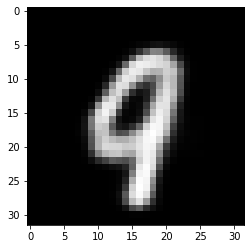

In [10]:
i=3
recon_img,_,_ = generator_model(torch.FloatTensor(example_data[i]).unsqueeze(0).to(device))
plt.imshow(recon_img[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

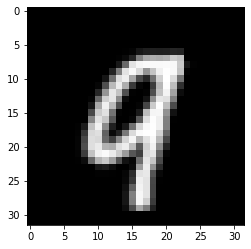

In [13]:
plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

In [14]:
# from torch.optim.lr_scheduler import StepLR
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.5)
#         self.fc1 = nn.Linear(12544, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         output = F.log_softmax(x, dim=1)
#         return output

# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
# #         data_hat,_,_ = vae_model(data)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))

# def test(model, vae_model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             data_hat,_,_ = vae_model(data)
#             data_hat.re
#             output = model(data_hat)
#             test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

In [15]:
# test_batch_size = 1000
# batch_size = 64
# epochs = 2
# lr = 0.1
# gamma = 0.7
# seed = 1
# no_cuda = False
# log_interval = 1000
# save_model = True
# use_cuda = True
# torch.manual_seed(seed)
# device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# model_classification = Net().to(device)
# optimizer = optim.Adadelta(model_classification.parameters(), lr=lr)



# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
# for epoch in range(1, epochs + 1):
#     train(model_classification, device, train_loader, optimizer, epoch)
#     test(model_classification, generator_model, device, test_loader)
#     scheduler.step()

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load('lenet_mnist_model.pth', map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [17]:
test_loader = DataLoader(mnist_dataset_test, batch_size=1, shuffle=True)

In [18]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [26]:
class Network(nn.Module):
    def __init__(self, generator, classifier, train=True):
        super(Network, self).__init__()
        self.generator = generator
        self.classifier = classifier
        self.train = train
    
    def forward(self, x):
        if self.train:
            self.generator.train()
        else:
            self.generator.eval()
        x, latent_distribution, latent_sample = self.generator(x)
        x = F.interpolate(x, size=28)
        x = self.classifier(x)
        return x, latent_sample

In [27]:
model_complete = Network(generator_model, model, train=True)

In [28]:
def test( model_complete, model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

#         data_hat, latent_distribution, latent_sample = generator(data)
#         data_hat = F.interpolate(data_hat, size=28)
#         print(latent_sample.requires_grad)
        # Set requires_grad attribute of tensor. Important for Attack
#         data_hat.requires_grad = True

        # Forward pass the data through the model
        output, latent_sample = model_complete(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model_complete.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = latent_sample.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(latent_sample, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(model_complete.generator.decoder(perturbed_data))

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [29]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda = True
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, generator_model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

RuntimeError: shape '[-1, 320]' is invalid for input of size 500

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()